# Review-Based QA System
------ 

Can you get the answers of specifc questions like “does this guitar come with a strap?” or “can I use this camera at night?” when you want to buy these products online?

It may be hard to answer from the product description alone.

One alternative is to post your question on the community QA platforms provided by websites like Amazon, but it usually takes days to get an answer (if at all).

It would be nice if we get an immediate answer like the Google Example below

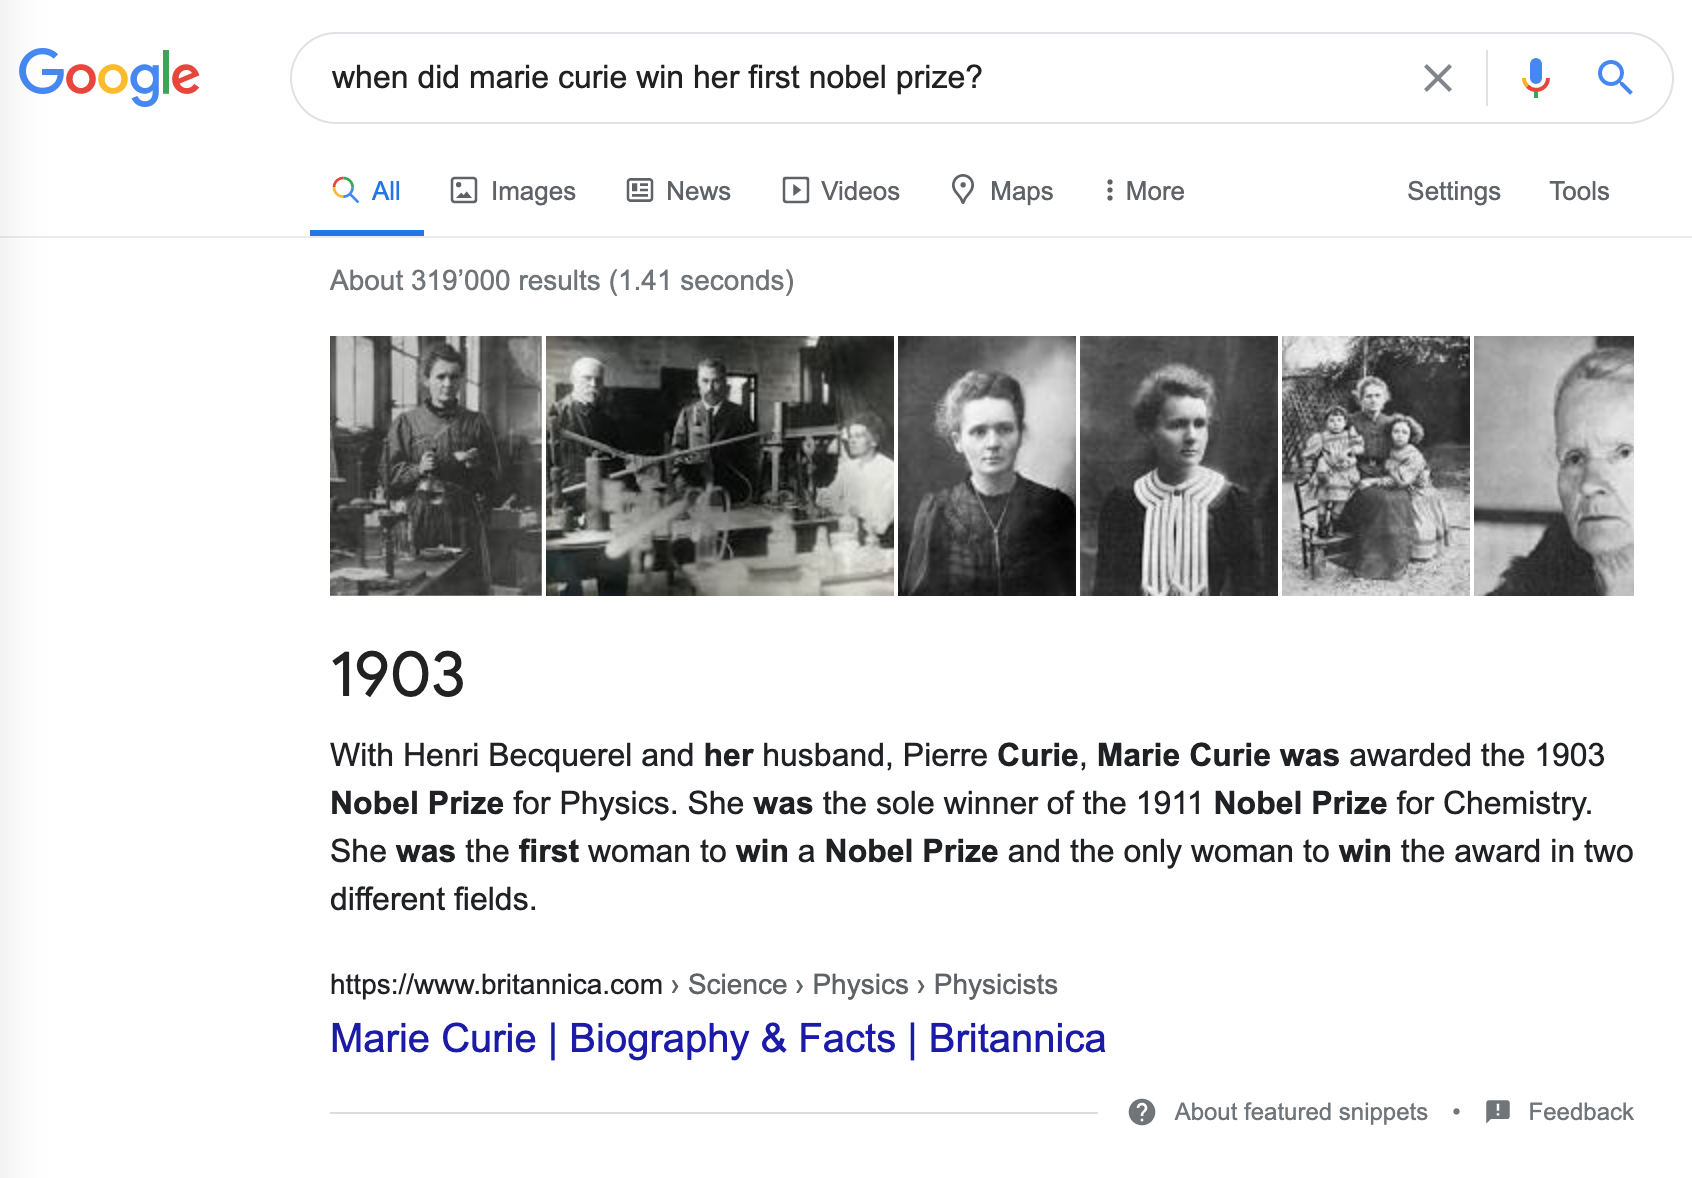

## Objective
------

To predict the answers of the question asked by the users by using the reviews of those products.

## The Dataset
--------

To build our QA system, we'll use SubjQA dataset which has 10K customer reviews in English about products and services in the areas of TripAdvisor, Restaurants, Movies, Books, Electronics, and Grocery. 

Firstly we'll focus on bulding the QA for the Electronics Domain, Lets' download the data from [Hugging Face Hub](https://huggingface.co/datasets/subjqa)

In [1]:
from datasets import load_dataset
import pandas as pd

subjqa = load_dataset("subjqa", "electronics")
subjqa.set_format("pandas")
# Flatten the nested dataset columns for easy access
dfs = {split:ds[:] for split, ds in subjqa.flatten().items()}

for split, df in dfs.items():
    print(f"Number of questions in {split}: {df['id'].nunique()}")

Reusing dataset subjqa (/home/ma/sparsh/.cache/huggingface/datasets/subjqa/electronics/1.1.0/e5588f9298ff2d70686a00cc377e4bdccf4e32287459e3c6baf2dc5ab57fe7fd)


  0%|          | 0/3 [00:00<?, ?it/s]

Number of questions in train: 1295
Number of questions in test: 358
Number of questions in validation: 255


We can notice that dataset is quite small with just 1908 examples, it cna simulate the real world scenario where we don't get much data as it quite labor-intensive and time consuming.

### Data Description

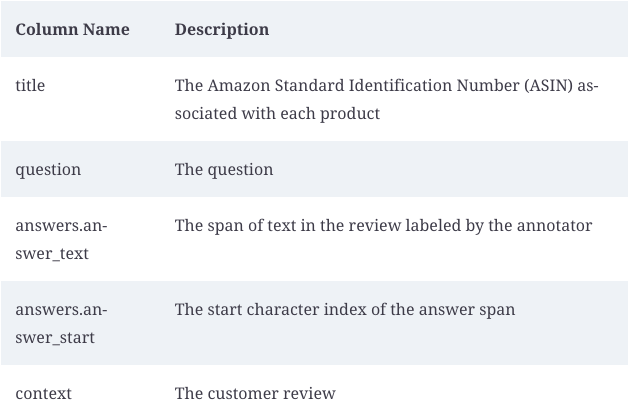

Lets check few examples of the Data

In [2]:
qa_cols = ["title", "question", "answers.text",
           "answers.answer_start", "context"]
sample_df = dfs["train"][qa_cols].sample(5, random_state=7)
sample_df

title                              question  \
791   B005DKZTMG        Does the keyboard lightweight?   
1159  B00AAIPT76                   How is the battery?   
961   B0074BW614         How is the cell phone screen?   
1188  B00BGGDVOO  Do you have any computer with mouse?   
999   B007P4VOWC                    How is the camera?   

                                           answers.text answers.answer_start  \
791                          [this keyboard is compact]                [215]   
1159                                                 []                   []   
961   [The interface takes a few tries to get used t...                [535]   
1188                                                 []                   []   
999                                                  []                   []   

                                                context  
791   I really like this keyboard.  I give it 4 star...  
1159  I bought this after the first spare gopro batt...  
961   Don't get me wrong, I love my e-ink kindle to ...  
1188  After deciding to ditch cable TV I started to ...  
999   I purchased the Tab 2 for my fianc&eacute; and...

From above examples we can make some observations:
- In answers.text are empty wehere labeler cant find the answers of the asked questions from the review context
- We can use the answers.answer_start to trace the answer from the context.

Let's check what type of questions are in the training set

In [25]:
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook, show  
from bokeh.resources import INLINE
output_notebook(resources=INLINE)
counts = {}
question_types = ["What", "How", "Is", "Does", "Do", "Was", "Where", "Why"]

for q in question_types:
    counts[q] = dfs["train"]["question"].str.startswith(q).value_counts()[True]
print(counts)
from bokeh.plotting import figure, output_file, show
xvals = list(counts.keys())
yvals = list(counts.values())
fig = figure(x_range = xvals, plot_width = 400, plot_height = 300)
#cols = ['navy','cyan','orange']
fig.vbar(x = xvals, top = yvals, width = 0.5)
show(fig)

Loading BokehJS ...

{'What': 236, 'How': 780, 'Is': 100, 'Does': 45, 'Do': 83, 'Was': 12, 'Where': 28, 'Why': 21}


We can observe that questions beginning with "How", "What", and "Is" are the most asked question, others are few in numbers. Let's check how these questions look like?

In [52]:
for question_type in ["How", "What", "Is"]:
    for question in dfs['train'].query("question.str.contains('%s')"%question_type, engine='python').sample(n=3, random_state=42)['question']:
        print(question)
    print()

How is the camera?
How do you like the control?
How fast is the charger?

What is direction?
What is the quality of the construction of the bag?
What is your impression of the product?

Is this how zoom works?
Is sound clear?
Is it a wireless keyboard?



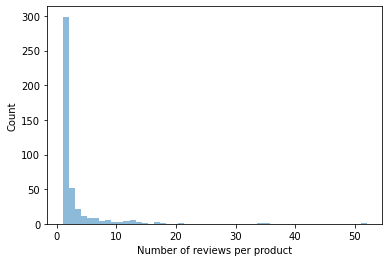

In [60]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
(dfs["train"].groupby("title")["review_id"].nunique().hist(bins=50, alpha=0.5, grid=False, ax=ax))
plt.xlabel("Number of reviews per product")
plt.ylabel("Count");

From above figure, we can see how labeled data is not balanced, to train a better model we should have better annotations, we can see mostly the products have just 1 review, only one product has more than 50 reviews.

## Extracting Answers from Text
----------

We need our system to find a way to identify the potential answer from the review. To do so, we need to undertand how to:

- Formulate the supervised learning problem
- Tokenize and Encoding the texts
- Deal with long passages if review crosses the max context size

Let's start with Supervised Learning Problem

### Span Classification

This is a most common way where model has to predict the start and end tokens of the answer and by using the tokens system can fetch it from the context review.

The process is illustrated below

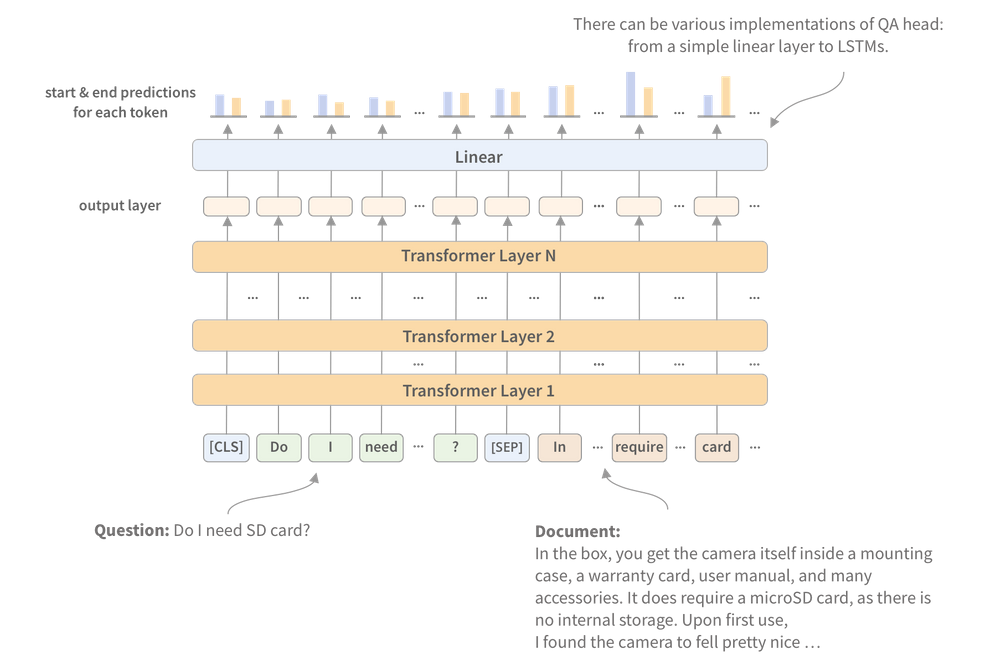

As our training set has very few training examples, the best strategy is to fine tuned the model which is pretrained on the large-scale QA dataset like SQuAD. 

We can use [Hugging Face Hub](https://huggingface.co/datasets/subjqa) to find the models which are pretrained on SQuAD dataset

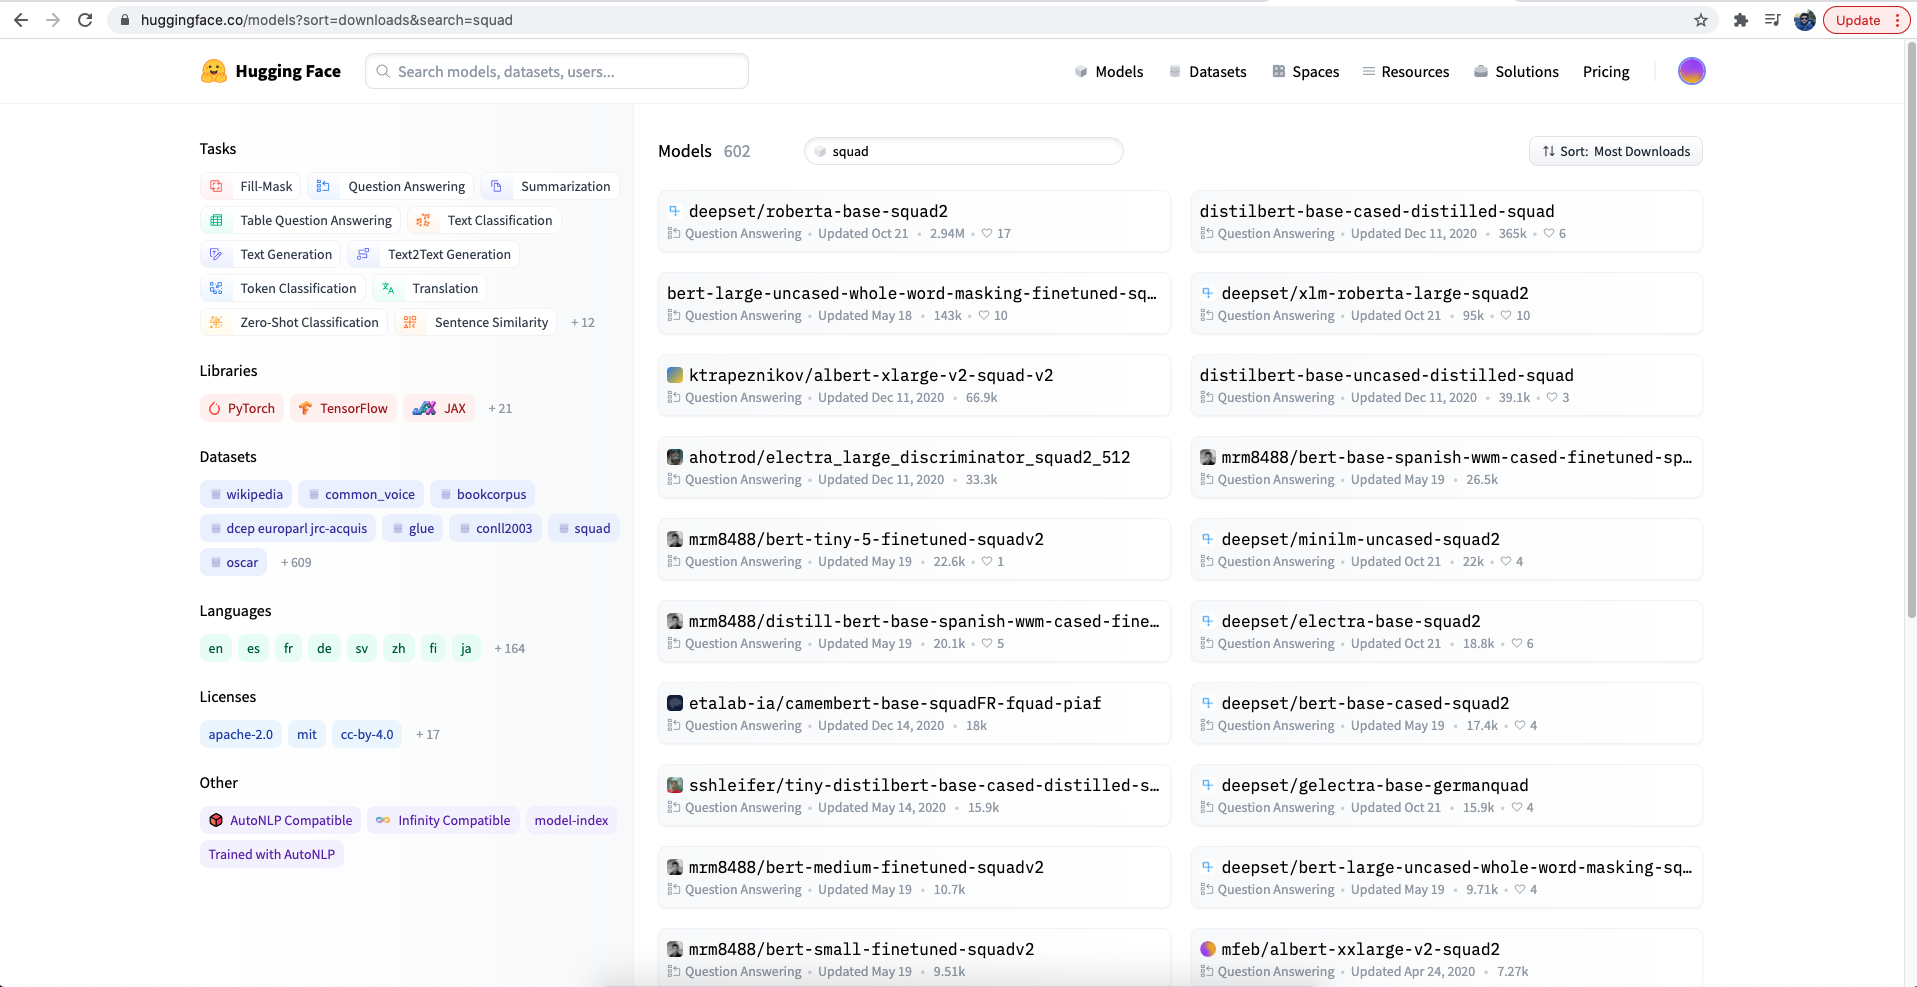

We can see over 600 QA models train on SQuAD, below table shows the baseline models that are finetuned on SQuAD 2.0

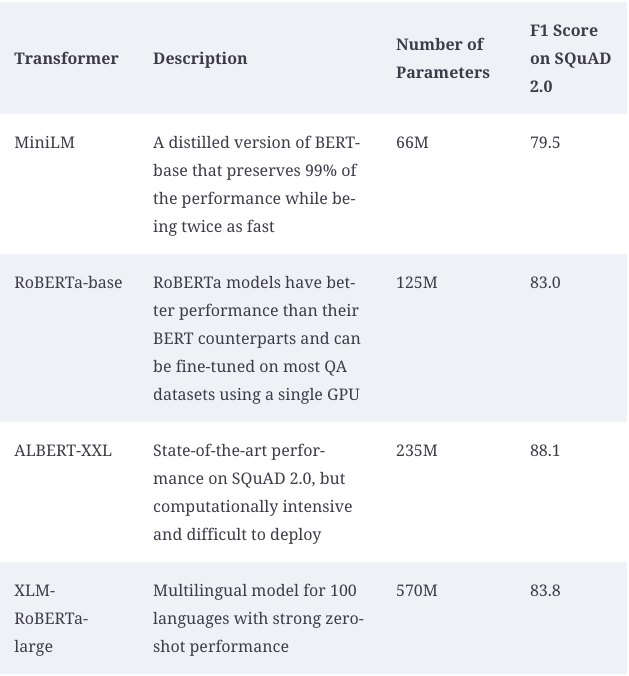


### Tokenize the Text
We'll try all the four pretrained models one by one and check which is performing best for our data.

#### MiniLM

In [76]:
from transformers import AutoTokenizer

model_ckpt = "deepset/minilm-uncased-squad2"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
question = "How much music can this hold?"
context = """An MP3 is about 1 MB/minute, so about 6000 hours depending on \
file size."""
inputs = tokenizer(question, context, return_tensors="pt")
print(inputs)

{'input_ids': tensor([[  101,  2129,  2172,  2189,  2064,  2023,  2907,  1029,   102,  2019,
         23378,  2003,  2055,  1015, 16914,  1013,  3371,  1010,  2061,  2055,
         25961,  2847,  5834,  2006,  5371,  2946,  1012,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1]])}


In the above data we have tensor_ids, attention mask which is expected, other that that we also got `token_type_ids` where 0 shows its a question token and 1 indicates a context(review) token, 
To understand it further, lets decode this tokenizer

In [77]:
tokenizer.decode(inputs["input_ids"][0])

'[CLS] how much music can this hold? [SEP] an mp3 is about 1 mb / minute, so about 6000 hours depending on file size. [SEP]'

The above decoder looks like `[CLS] question tokens [SEP] context tokens [SEP]`

Let's initiate the model with QA head and run the inputs to get the outputs

In [78]:
from transformers import AutoModelForQuestionAnswering
import torch

model = AutoModelForQuestionAnswering.from_pretrained(model_ckpt)
outputs = model(**inputs)
start_scores = outputs.start_logits
end_scores = outputs.end_logits
start_idx = torch.argmax(start_scores)
end_idx = torch.argmax(end_scores) + 1
answer_span = inputs["input_ids"][0][start_idx:end_idx]
answer = tokenizer.decode(answer_span)
print(f"Question: {question}")
print(f"Answer: {answer}")

Question: How much music can this hold?
Answer: 6000 hours


We can also use HuggingFace dedicated `QuestionAnsweringPipeline` for all of these preprocessing and poset-processing steps.

In [79]:
from transformers import QuestionAnsweringPipeline

pipe = QuestionAnsweringPipeline(model=model, tokenizer=tokenizer)
pipe(question=question, context=context, topk=3)

[{'score': 0.26516181230545044,
  'start': 38,
  'end': 48,
  'answer': '6000 hours'},
 {'score': 0.2208295613527298,
  'start': 16,
  'end': 48,
  'answer': '1 MB/minute, so about 6000 hours'},
 {'score': 0.10253508388996124,
  'start': 16,
  'end': 27,
  'answer': '1 MB/minute'}]

#### RoBERTta-base

In [81]:
model_ckpt = "deepset/roberta-base-squad2"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
question = "How much music can this hold?"
context = """An MP3 is about 1 MB/minute, so about 6000 hours depending on \
file size."""
inputs = tokenizer(question, context, return_tensors="pt")
tokenizer.decode(inputs["input_ids"][0])
from transformers import QuestionAnsweringPipeline
model = AutoModelForQuestionAnswering.from_pretrained(model_ckpt)
pipe = QuestionAnsweringPipeline(model=model, tokenizer=tokenizer)
pipe(question=question, context=context, topk=3)

[{'score': 0.28984391689300537,
  'start': 16,
  'end': 27,
  'answer': '1 MB/minute'},
 {'score': 0.10971591621637344,
  'start': 16,
  'end': 48,
  'answer': '1 MB/minute, so about 6000 hours'},
 {'score': 0.07470730692148209,
  'start': 10,
  'end': 27,
  'answer': 'about 1 MB/minute'}]

From Roberta-base, we can see results are not good for this query, 

#### ALBERT-XXL

In [82]:
model_ckpt = "distilbert-base-cased-distilled-squad"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
question = "How much music can this hold?"
context = """An MP3 is about 1 MB/minute, so about 6000 hours depending on \
file size."""
inputs = tokenizer(question, context, return_tensors="pt")
tokenizer.decode(inputs["input_ids"][0])
from transformers import QuestionAnsweringPipeline
model = AutoModelForQuestionAnswering.from_pretrained(model_ckpt)
pipe = QuestionAnsweringPipeline(model=model, tokenizer=tokenizer)
pipe(question=question, context=context, topk=3)

[{'score': 0.41336461901664734,
  'start': 38,
  'end': 48,
  'answer': '6000 hours'},
 {'score': 0.22129644453525543,
  'start': 16,
  'end': 48,
  'answer': '1 MB/minute, so about 6000 hours'},
 {'score': 0.07070951908826828,
  'start': 16,
  'end': 27,
  'answer': '1 MB/minute'}]

From ALBERT-XXL, we can see results are same compared to MiniLM but overall score for top 3 answers is improved 

#### XLM-RoBERTa-Large

In [ ]:
from transformers import AutoModelForQuestionAnswering, AutoTokenizer
model_ckpt = "deepset/xlm-roberta-large-squad2"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
question = "How much music can this hold?"
context = """An MP3 is about 1 MB/minute, so about 6000 hours depending on \
file size."""
inputs = tokenizer(question, context, return_tensors="pt")
tokenizer.decode(inputs["input_ids"][0])
from transformers import QuestionAnsweringPipeline
model = AutoModelForQuestionAnswering.from_pretrained(model_ckpt)
pipe = QuestionAnsweringPipeline(model=model, tokenizer=tokenizer)
pipe(question=question, context=context, topk=3)

### Dealing with Long Passages

For tasks like Text classification we can simply truncate long texts after making the assumption that we'll have enough information to generate accurate predictions.

But for QA, there may be a chance that answer lies at the end which would be removed by truncation as showed by below image.
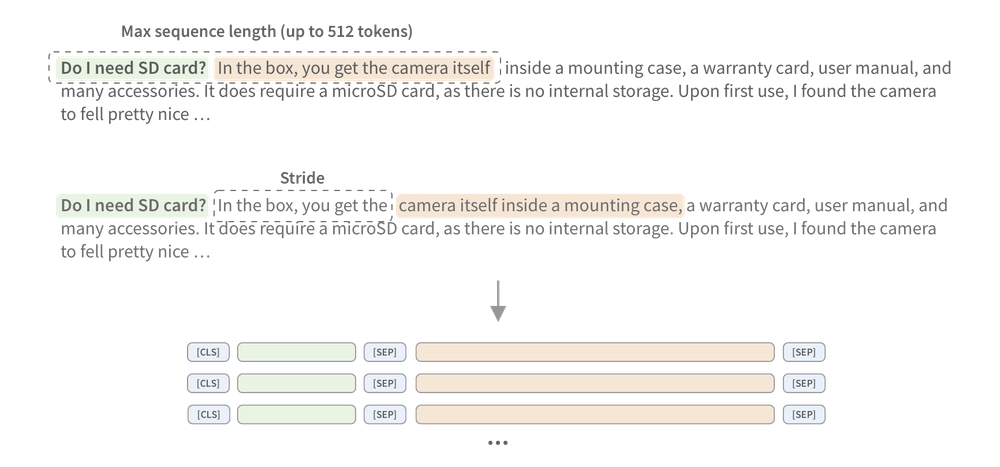

The standard way is to apply sliding window across the inputs.

In [88]:
example = dfs["train"].iloc[0][["question", "context"]]
tokenized_example = tokenizer(example["question"], example["context"],
                              return_overflowing_tokens=True, max_length=100,
                              stride=25)
for idx, window in enumerate(tokenized_example["input_ids"]):
    print(f"Window #{idx} has {len(window)} tokens")
    print(tokenizer.decode(window), "\n")

Window #0 has 100 tokens
[CLS] How is the bass? [SEP] I have had Koss headphones in the past, Pro 4AA and QZ - 99. The Koss Portapro is portable AND has great bass response. The work great with my Android phone and can be " rolled up " to be carried in my motorcycle jacket or computer bag without getting crunched. They are very light and don't feel heavy or bear down on your ears even after listening to music with them on all day. The sound is [SEP] 

Window #1 has 89 tokens
[CLS] How is the bass? [SEP] and don't feel heavy or bear down on your ears even after listening to music with them on all day. The sound is night and day better than any ear - bud could be and are almost as good as the Pro 4AA. They are " open air " headphones so you cannot match the bass to the sealed types, but it comes close. For $ 32, you cannot go wrong. [SEP] 



## QA Pipeline using Haystack
----

For now we are providing both question and the context to the model but in reality users will provide a question about a product. so we need some way of selective relevant passages from all the reviews in the corpus.
- One way is to concatanate all the reviews in a single long context,but the drawback can be latency
- to handle above problem QA systems are typically based on Retriever-Reader architecture

#### Retriever: 
Retrieves relevant documents for a query. It can be sparse and dense.
#### Reader: 
Responisble for extracting an answer fromt he documents provided by Retriever

Apart from the above components there can be some other components that may apply post-processing to the documents fetched by Retriever or to the answers fetched by Reader like the image below

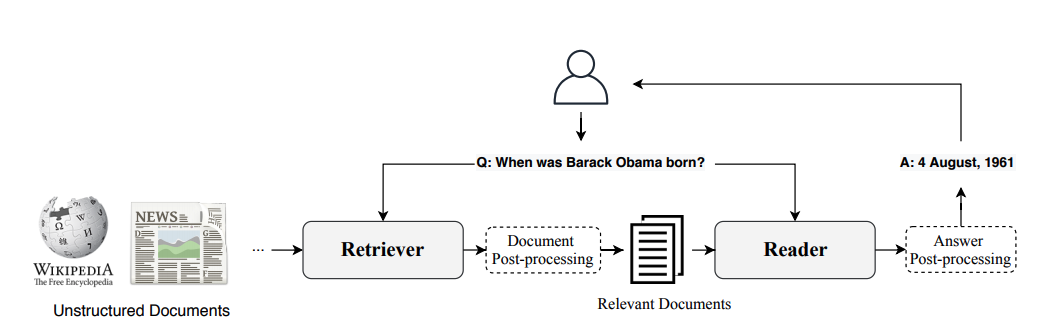